In [1]:
# %%
# create data use DWT and fuzz c-mean
# logic matrix sau khi qua tiền xử lý là DWT sẽ được tính fuzz c-mean
# sau đó lưu lại data set với lượng feature mới
import pywt
import numpy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation, \
    OneD_SymbolicAggregateApproximation
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import *
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Flatten, ReLU
#gpu = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpu[1], True)
import pandas as pd
from IPython.display import display, HTML

2025-06-01 08:22:34.379557: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 08:22:34.551796: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 08:22:34.688921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748740954.831122    2231 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748740954.863814    2231 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

In [2]:
import os
from scipy.io import loadmat
from scipy.interpolate import interp1d
directory = 'Dataset/Chuong Duong'

all_data = {}

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.mat'):
        filepath = os.path.join(directory, filename)
        # Load the .mat file and add its contents to the dictionary
        mat_data = loadmat(filepath)
        
        # Use filename (without extension) as key for the data
        key = os.path.splitext(filename)[0]
        all_data[key] = mat_data['acceleration']
        print(filepath)
        print(mat_data)

Dataset/Chuong Duong/ChuongDuong5.mat
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Aug  5 13:22:10 2024', '__version__': '1.0', '__globals__': [], 'acceleration': array([[ 0.00000000e+00, -1.76938762e-05,  1.93218752e-05, ...,
         3.20232276e-05,  3.98200632e-05,  0.00000000e+00],
       [ 0.00000000e+00, -2.74850791e-05,  3.98295374e-05, ...,
         5.82745773e-05,  6.57308542e-05,  0.00000000e+00],
       [ 0.00000000e+00, -3.22212570e-05,  5.97583067e-05, ...,
         7.95689663e-05,  8.19141888e-05,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  9.58576323e-06,  1.43233287e-05, ...,
         3.47126009e-05,  6.43548549e-05,  0.00000000e+00],
       [ 0.00000000e+00,  1.98457594e-05,  2.23331376e-05, ...,
         3.18232324e-05,  4.55212093e-05,  0.00000000e+00],
       [ 0.00000000e+00,  2.54074286e-05,  2.37467243e-05, ...,
         1.95918117e-05,  1.24411731e-05,  0.00000000e+00]])}
Dataset/Chuong Duong/ChuongDuong8.mat
{'__header__'

In [3]:
keys_to_stack = [f'ChuongDuong{i}' for i in range(11)]
input_data = np.stack([all_data[key] for key in keys_to_stack], axis=0)
print(all_data.keys)

# Create the corresponding labels
output_labels = np.linspace(0,10,11)  # Using 0 and 1 as class labels for binary cross-entropy
labels = output_labels

input_data = input_data[:,:,:40000]
input_data.shape, output_labels.shape

<built-in method keys of dict object at 0x7faa7983fac0>


((11, 40, 40000), (11,))

(40, 40000)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


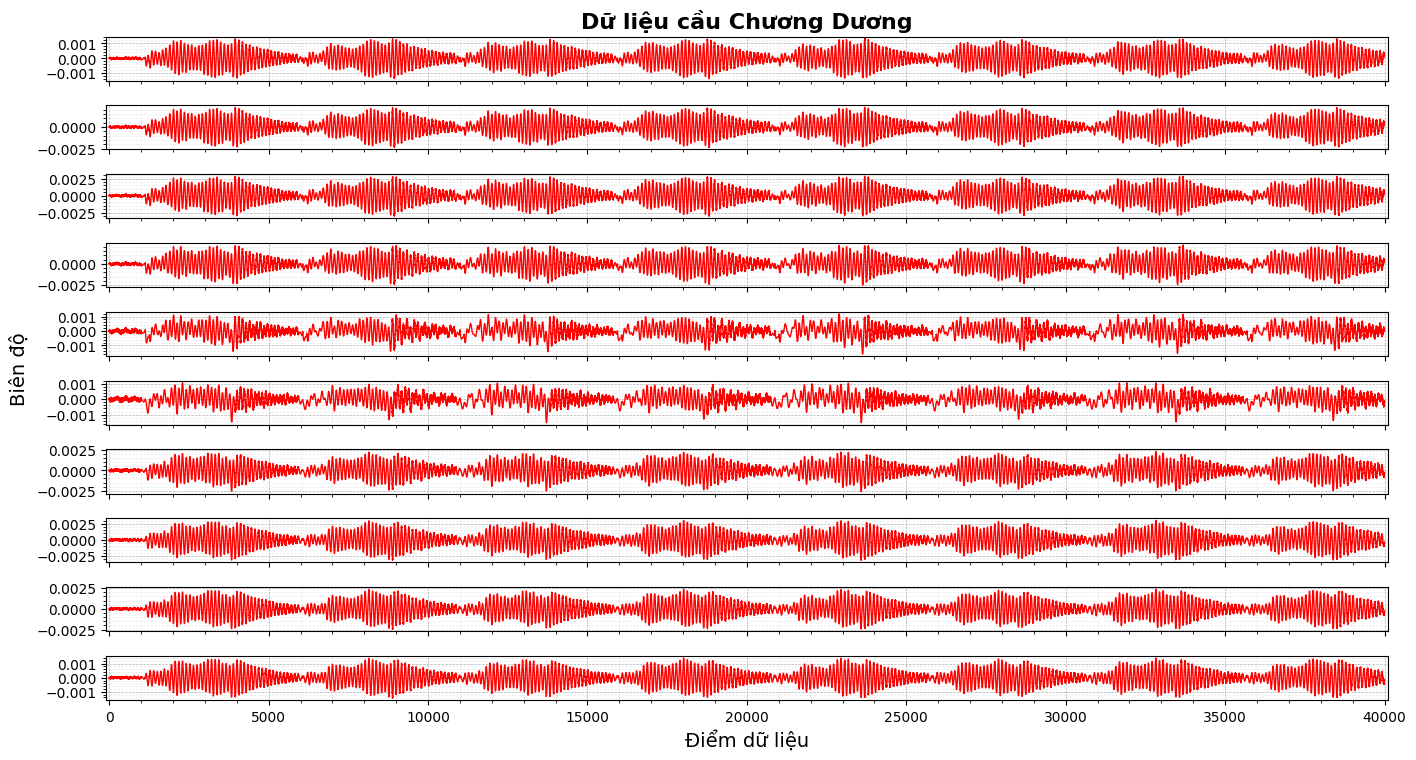

In [4]:
# Select the data at index (1, 1, :) which has a shape of (50000,)
Data = input_data[5, :, :]
print(Data.shape)
# Create the plot
fig, axes = plt.subplots(input_data.shape[1]-30, 1, figsize=(15, 8), sharex=True)

title_font = {'family': 'Times New Roman', 'size': 16, 'weight': 'bold'}
label_font = {'family': 'Times New Roman', 'size': 14}
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.family'] = 'sans-serif'
#print(axes)
# Plot the data for each sub-array
for i, ax in enumerate(axes):
    ax.plot(Data[i, :], linewidth=1, color = 'r')
    # ax.set_title(f'Z24 Signal Data at Index (1, {i}, :)', fontsize=12)
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.minorticks_on()
    ax.grid(True, which='minor', color='#999999', linestyle='--', alpha=0.2)
    ax.set_xlim(-100, Data.shape[1]+100)
# Set common labels using axes
axes[-1].set_xlabel('Điểm dữ liệu', fontsize=14, fontdict=label_font)
axes[0].set_title('Dữ liệu cầu Chương Dương', fontsize=16, fontdict=title_font)

# Create a "super" axis for the common Y-label and make it invisible
super_ax = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
super_ax.set_ylabel("Biên độ", fontsize=14, labelpad=15, fontdict=label_font)

# Move the super axis ylabel to avoid overlap with subplots
super_ax.yaxis.set_label_coords(-0.06,0.5)

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.show()

In [5]:
import numpy as np
import random

def augment_time_series_data(input_data, labels, num_augmentations=5):
    """
    Augment time series data.

    :param input_data: Original time series data array.
    :param labels: Corresponding labels for the data.
    :param num_augmentations: Number of augmented samples to generate per original sample.

    :return: Augmented data array and corresponding labels.
    """
    augmented_data = []
    augmented_labels = []

    num_samples, num_channels, sequence_length = input_data.shape
    #print (sequence_length)

    for i in range(num_samples):
        for _ in range(num_augmentations):
            # Choose a random augmentation technique
            augmentation_type = random.choice(['noise', 'reverse', 'crop_pad'])

            if augmentation_type == 'noise':
                # Add random noise
                noise = np.random.normal(0, 0.001, input_data[i].shape)
                augmented_sample = input_data[i] + noise

            elif augmentation_type == 'reverse':
                # Reverse the sequence
                augmented_sample = np.flip(input_data[i], axis=-1)

            elif augmentation_type == 'crop_pad':
                # Crop and pad the sequence
                crop_size = random.randint(0, sequence_length // 100)
                padded_sample = np.pad(input_data[i], ((0, 0), (crop_size, 0)), mode='constant', constant_values=0)
                augmented_sample = padded_sample[:, :-crop_size]

            augmented_data.append(augmented_sample)
            augmented_labels.append(labels[i])

    # Convert to numpy arrays
    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)

    return augmented_data, augmented_labels

# Sử dụng hàm
augmented_data, augmented_labels = augment_time_series_data(input_data, output_labels)
print(augmented_data.shape, augmented_labels.shape)

(55, 40, 40000) (55,)


(40, 40000)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


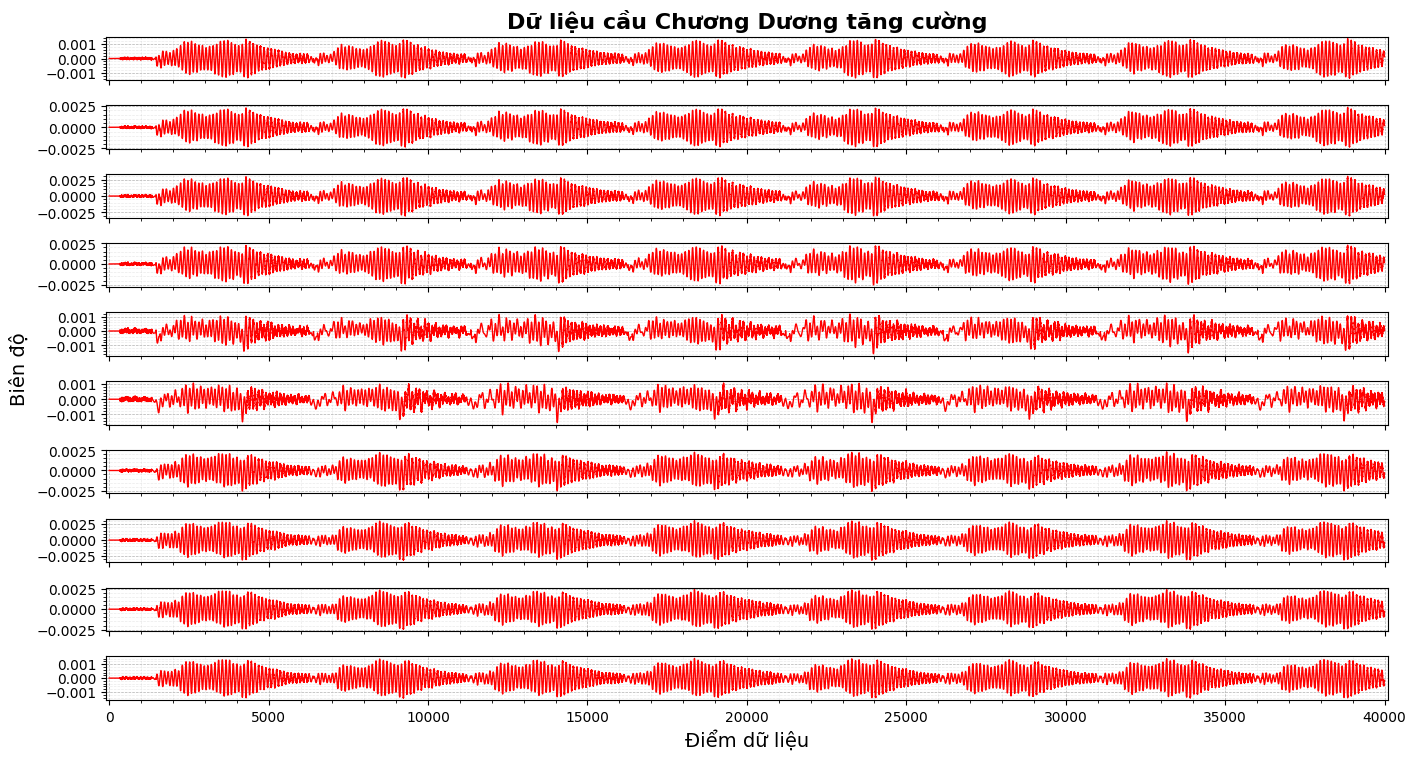

In [6]:
# Select the data at index (1, 1, :) which has a shape of (50000,)
Data = augmented_data[18, :, :]
print(Data.shape)
# Create the plot
fig, axes = plt.subplots(input_data.shape[1]-30, 1, figsize=(15, 8), sharex=True)

title_font = {'family': 'Times New Roman', 'size': 16, 'weight': 'bold'}
label_font = {'family': 'Times New Roman', 'size': 14}
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.family'] = 'sans-serif'
#print(axes)
# Plot the data for each sub-array
for i, ax in enumerate(axes):
    ax.plot(Data[i, :], linewidth=1, color = 'r')
    # ax.set_title(f'Z24 Signal Data at Index (1, {i}, :)', fontsize=12)
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.minorticks_on()
    ax.grid(True, which='minor', color='#999999', linestyle='--', alpha=0.2)
    ax.set_xlim(-100, Data.shape[1]+100)
# Set common labels using axes
axes[-1].set_xlabel('Điểm dữ liệu', fontsize=14, fontdict=label_font)
axes[0].set_title('Dữ liệu cầu Chương Dương tăng cường', fontsize=16, fontdict=title_font)

# Create a "super" axis for the common Y-label and make it invisible
super_ax = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
super_ax.set_ylabel("Biên độ", fontsize=14, labelpad=15, fontdict=label_font)

# Move the super axis ylabel to avoid overlap with subplots
super_ax.yaxis.set_label_coords(-0.06,0.5)

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.show()

In [7]:
import numpy as np

def reshape_time_series_data_v8(input_data, label_data, segments_per_new_sample, segment_length):
    """
    Reshape time series data and corresponding labels into a specified shape.

    :param input_data: Original time series data array.
    :param label_data: Corresponding labels for the data.
    :param segments_per_new_sample: Number of segments per new sample.
    :param segment_length: Length of each segment.

    :return: Reshaped data array and corresponding labels.
    """
    num_samples_original, num_channels, length_original = input_data.shape

    # Validate the feasibility of reshaping
    if length_original % segment_length != 0:
        raise ValueError("Segment length must evenly divide the original length.")

    total_segments_per_original_sample = (length_original // segment_length) * num_channels
    num_samples_new = (num_samples_original * total_segments_per_original_sample) // segments_per_new_sample

    # Validate if reshaping is possible
    if (num_samples_original * total_segments_per_original_sample) % segments_per_new_sample != 0:
        raise ValueError("Reshaping not possible with the given dimensions.")

    # Initialize reshaped data and labels
    new_shape = (num_samples_new, segments_per_new_sample, segment_length)
    reshaped_data = np.zeros(new_shape)
    reshaped_labels = np.zeros(num_samples_new)

    # Reshape the data and labels
    count = 0
    for i in range(num_samples_original):
        segment_count = 0
        for j in range(num_channels):
            for k in range(length_original // segment_length):
                start_idx = k * segment_length
                end_idx = start_idx + segment_length
                reshaped_data[count, segment_count % segments_per_new_sample, :] = input_data[i, j, start_idx:end_idx]
                if (segment_count + 1) % segments_per_new_sample == 0:
                    reshaped_labels[count] = label_data[i]  # Assign corresponding label
                    count += 1
                segment_count += 1

    return reshaped_data, reshaped_labels

# Example usage
segments_per_new_sample = 8
segment_length = 5000

# Assume 'augmented_data' and 'augmented_labels' are your input data and labels
reshaped_data, reshaped_labels = reshape_time_series_data_v8(augmented_data, augmented_labels, segments_per_new_sample, segment_length)
print(reshaped_data.shape, reshaped_labels.shape)


(2200, 8, 5000) (2200,)


(8, 5000)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


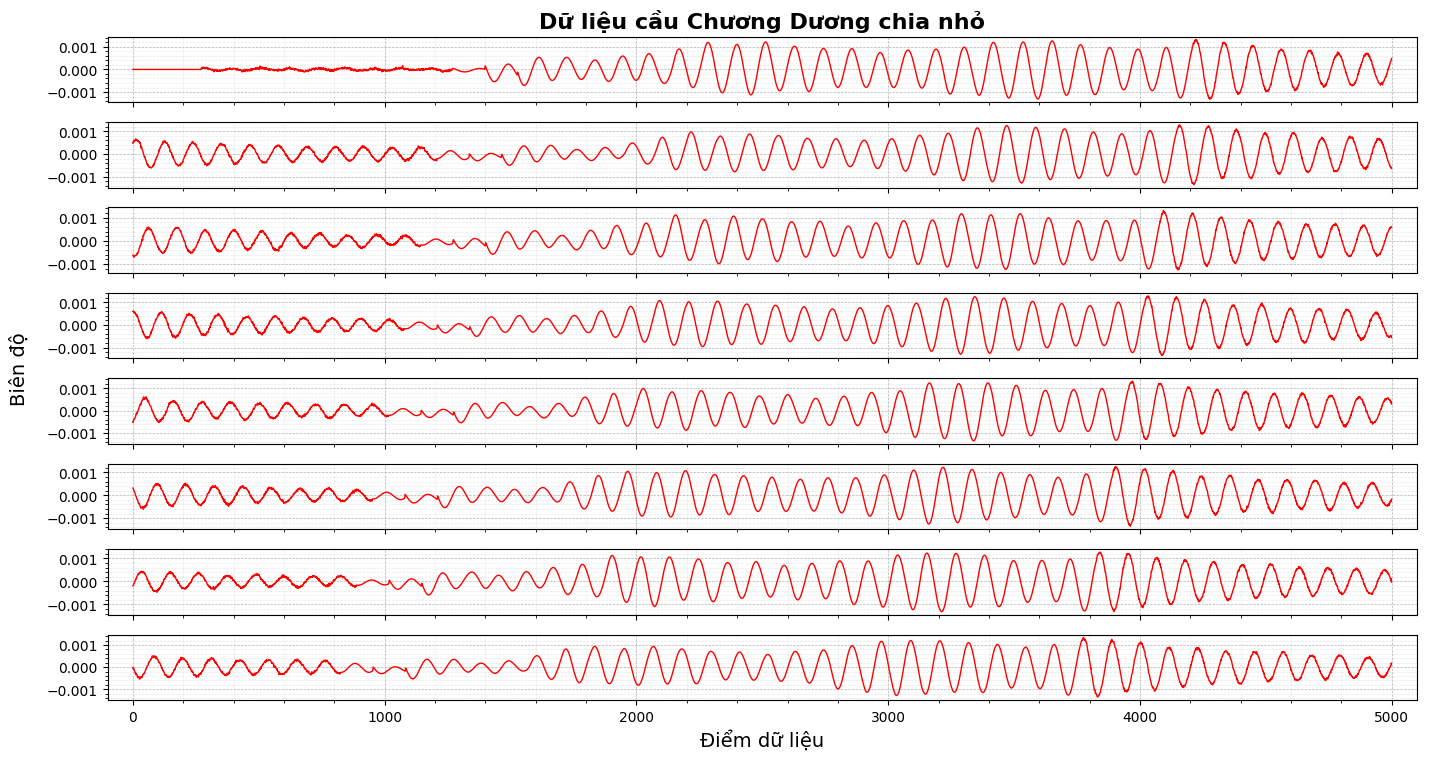

In [8]:

# Select the data at index (1, 1, :) which has a shape of (8000,)
Data = reshaped_data[200, :, :] #150 -> 200
print(Data.shape)
# Create the plot
fig, axes = plt.subplots(reshaped_data.shape[1], 1, figsize=(15, 8), sharex=True)

title_font = {'family': 'Times New Roman', 'size': 16, 'weight': 'bold'}
label_font = {'family': 'Times New Roman', 'size': 14}
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.family'] = 'sans-serif'

# Plot the data for each sub-array
for i, ax in enumerate(axes):
    ax.plot(Data[i, :], linewidth=1, color = 'r')
    # ax.set_title(f'Z24 Signal Data at Index (1, {i}, :)', fontsize=12)
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.minorticks_on()
    ax.grid(True, which='minor', color='#999999', linestyle='--', alpha=0.2)
    ax.set_xlim(-100, Data.shape[1]+100)
# Set common labels using axes
axes[-1].set_xlabel('Điểm dữ liệu', fontsize=14, fontdict=label_font)
axes[0].set_title('Dữ liệu cầu Chương Dương chia nhỏ', fontsize=16, fontdict=title_font)

# Create a "super" axis for the common Y-label and make it invisible
super_ax = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
super_ax.set_ylabel("Biên độ", fontsize=14, labelpad=15, fontdict=label_font)

# Move the super axis ylabel to avoid overlap with subplots
super_ax.yaxis.set_label_coords(-0.06,0.5)

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.show()

In [9]:

# input_train = reshaped_data
# output_train = reshaped_labels
# XXX_train, XXX_valid, y_train, y_valid = train_test_split(input_train, output_train, test_size=0.4, random_state=42)


# Assuming reshaped_data and reshaped_labels are defined
input_train = reshaped_data  # Original shape is (924, 10, 5000)
output_train = reshaped_labels

# Split the data into training and validation sets
XXX_train_reshaped, XXX_valid_reshaped, y_train, y_valid = train_test_split(input_train, output_train, test_size=0.2, random_state=42)

# Now, reshape XXX_train and XXX_valid from (N, 10, 5000) to (N, 5000, 10)
XXX_train = XXX_train_reshaped.reshape(XXX_train_reshaped.shape[0], 5000, 8)
XXX_valid = XXX_valid_reshaped.reshape(XXX_valid_reshaped.shape[0], 5000, 8)

# Print the shapes to verify
print(XXX_train.shape)
print(XXX_valid.shape)


(1760, 5000, 8)
(440, 5000, 8)


In [10]:

# %%
XXX_train = np.reshape(XXX_train, (XXX_train.shape[0], XXX_train.shape[2], XXX_train.shape[1]))
XXX_valid = np.reshape(XXX_valid, (XXX_valid.shape[0], XXX_valid.shape[2], XXX_valid.shape[1]))
label=np.unique(y_train)
print(XXX_train.shape)
print(XXX_valid.shape)


(1760, 8, 5000)
(440, 8, 5000)


<h3><i>Process .mat file data</i><h3>

In [11]:
def segment_data(data, labels, seg_per_sample=8, seg_len=1024):
    X = []
    Y = []
    for i in range(len(data)):
        for c in range(data[i].shape[0]):
            num_segs = data[i].shape[1] // seg_len
            for j in range(num_segs):
                segment = data[i][c, j*seg_len:(j+1)*seg_len]
                X.append(segment)
                Y.append(labels[i])
    return np.array(X), np.array(Y)

seg_data, seg_labels = segment_data(input_data, labels, seg_per_sample=8, seg_len=1024)
# seg_data shape: (N, 1024)


In [12]:
def reshape_to_image(data_1d, image_size=(32, 32)):
    reshaped = np.array([x[:image_size[0]*image_size[1]].reshape(image_size) for x in data_1d])
    reshaped = reshaped[:, np.newaxis, :, :]  # (N, 1, H, W)
    return reshaped

img_data = reshape_to_image(seg_data)  # shape: (N, 1, 32, 32)


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

class MatDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MatDataset(data_2d, labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

NameError: name 'data_2d' is not defined

<h3><i>BUILD CROSSFORMER MODEL</i></h3>

In [ ]:
class Mlp(nn.Module):
    r"""2-layer MLP"""
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [ ]:
def build_model(config, args):
    model_type = config.MODEL.TYPE
    if model_type == 'cross-scale':
        if config.MODEL.CROS.GROUP_TYPE in ['constant', 'linear', 'linear_div', 'alter', '7_14']:
            from .crossformer import CrossFormer
        else:
            raise NotImplementedError(f"Unkown group type: {args.group_type}")

        model = CrossFormer(img_size=config.DATA.IMG_SIZE,
                                patch_size=config.MODEL.CROS.PATCH_SIZE,
                                in_chans=config.MODEL.CROS.IN_CHANS,
                                num_classes=config.MODEL.NUM_CLASSES,
                                embed_dim=config.MODEL.CROS.EMBED_DIM,
                                depths=config.MODEL.CROS.DEPTHS,
                                num_heads=config.MODEL.CROS.NUM_HEADS,
                                group_size=config.MODEL.CROS.GROUP_SIZE,
                                crs_interval=config.MODEL.CROS.INTERVAL,
                                mlp_ratio=config.MODEL.CROS.MLP_RATIO,
                                qkv_bias=config.MODEL.CROS.QKV_BIAS,
                                qk_scale=config.MODEL.CROS.QK_SCALE,
                                drop_rate=config.MODEL.DROP_RATE,
                                drop_path_rate=config.MODEL.DROP_PATH_RATE,
                                ape=config.MODEL.CROS.APE,
                                patch_norm=config.MODEL.CROS.PATCH_NORM,
                                use_checkpoint=config.TRAIN.USE_CHECKPOINT,
                                merge_size=config.MODEL.CROS.MERGE_SIZE,
                                group_type=config.MODEL.CROS.GROUP_TYPE,
                                use_cpe=config.MODEL.CROS.USE_CPE,
                                pad_type=config.MODEL.CROS.PAD_TYPE,
                                no_mask=config.MODEL.CROS.NO_MASK,
                                adaptive_interval=config.MODEL.CROS.ADAPT_INTER,
                                use_acl=config.MODEL.CROS.USE_ACL)
    else:
        raise NotImplementedError(f"Unkown model: {model_type}")

    return model


In [ ]:
def __init__(self, img_size=224, patch_size=[4], in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 group_size=[7, 7, 7, 7], crs_interval=[8, 4, 2, 1], mlp_ratio=4., 
                 qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, merge_size=[[2], [2], [2]], use_cpe=False,
                 group_type='constant', pad_type=0, no_mask=False,
                 adaptive_interval=False, use_acl=False,  **kwargs):
    super().__init__()

    self.num_classes = num_classes
    self.num_layers = len(depths)
    self.embed_dim = embed_dim
    self.ape = ape
    self.patch_norm = patch_norm
    self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
    self.mlp_ratio = mlp_ratio

    # split image into non-overlapping patches
    self.patch_embed = PatchEmbed(
        img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
        norm_layer=norm_layer if self.patch_norm else None)
    num_patches = self.patch_embed.num_patches
    patches_resolution = self.patch_embed.patches_resolution
    self.patches_resolution = patches_resolution

    # absolute position embedding
    if self.ape:
        self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        trunc_normal_(self.absolute_pos_embed, std=.02)

    self.pos_drop = nn.Dropout(p=drop_rate)

    # stochastic depth
    dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

    # compute group size for each layer
    group_size = self.compute_group_size(group_size, depths, patches_resolution, group_type)

    # build layers
    self.layers = nn.ModuleList()

    num_patch_sizes = [len(patch_size)] + [len(m) for m in merge_size]
    for i_layer in range(self.num_layers):
        patch_size_end = merge_size[i_layer] if i_layer < self.num_layers - 1 else None
        num_patch_size = num_patch_sizes[i_layer]
        layer = Stage(dim=int(embed_dim * 2 ** i_layer),
                            input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                patches_resolution[1] // (2 ** i_layer)),
                            depth=depths[i_layer],
                            num_heads=num_heads[i_layer],
                            group_size=group_size[i_layer],
                            interval=crs_interval[i_layer],
                            mlp_ratio=self.mlp_ratio[i_layer],
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                            norm_layer=norm_layer,
                            downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                            use_checkpoint=use_checkpoint,
                            patch_size_end=patch_size_end,
                            num_patch_size=num_patch_size,
                            use_cpe=use_cpe,
                            pad_type=pad_type,
                            no_mask=no_mask,
                            adaptive_interval=adaptive_interval,
                            use_acl=use_acl)
        self.layers.append(layer)

    self.norm = norm_layer(self.num_features)
    self.avgpool = nn.AdaptiveAvgPool1d(1)
    self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

    self.apply(self._init_weights)

In [ ]:
def compute_group_size(self, group_size=[7, 7, 7, 7], depths=[2, 2, 6, 2], resolution=[56, 56], group_type='constant'):
    r"""genenrate group size for crossformer
    
    output:
        - rst_group_size: should be in the shape [[4], [4, 4], [14, 14, 14], [7, 7]] if the depths = [1, 2, 3, 2]
    """
    rst_group_size = []

    # compute linear fraction patch size
    min_size = 4
    total_depth = sum(depths)
    step_size = (1 - min_size / resolution[0]) / total_depth
    group_fraction = np.arange(min_size / resolution[0], 1.0, step_size)

    cnt = 0
    for i_stage in range(len(depths)):
        rst_group_size.append([])
        cur_resolution = resolution[0] // 2 ** i_stage
        for i_block in range(depths[i_stage]):
            if group_type == 'constant':
                # constant group size for each stage
                rst_group_size[i_stage].append(group_size[i_stage])
            elif group_type == 'linear':
                # the fraction of group size relative to input resolution grow in linear
                gz = cur_resolution * group_fraction[cnt]
                rst_group_size[i_stage].append(max(4, int(np.ceil(gz))))
            elif group_type == 'linear_div':
                # if fraction > 1/2, let fraction = 1/2 if fraction < 3/4 else 1
                gz = cur_resolution * group_fraction[cnt]
                if gz > cur_resolution // 2:
                    gz = cur_resolution if gz > cur_resolution * 3 / 4 or i_stage != 2 else cur_resolution // 2
                rst_group_size[i_stage].append(max(4, int(np.ceil(gz))))
            elif group_type == 'alter':
                # if fraction > 1/2, let fraction alter between 1/2 and 1
                gz = cur_resolution * group_fraction[cnt]
                if gz > cur_resolution // 2:
                    gz = cur_resolution if cnt % 2 != 0 or i_stage != 2 else cur_resolution // 2
                rst_group_size[i_stage].append(max(4, int(np.ceil(gz))))
            elif group_type == '7_14':
                rst_group_size[i_stage].append(group_size[i_stage] if i_stage != 2 or i_block >= 4 else group_size[i_stage] // 2) 
            cnt += 1

    print("Group Size:")
    print(rst_group_size)

    return rst_group_size

In [ ]:
def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

@torch.jit.ignore
def no_weight_decay(self):
    return {'absolute_pos_embed'}

@torch.jit.ignore
def no_weight_decay_keywords(self):
    return {'relative_position_bias_table'}

def forward_features(self, x):
    x = self.patch_embed(x)
    if self.ape:
        x = x + self.absolute_pos_embed
    x = self.pos_drop(x)

    for layer in self.layers:
        x = layer(x)

    x = self.norm(x)  # B L C
    x = self.avgpool(x.transpose(1, 2))  # B C 1
    x = torch.flatten(x, 1)
    return x

def forward(self, x):
    x = self.forward_features(x)
    x = self.head(x)
    return x

def flops(self):
    flops = 0
    flops += self.patch_embed.flops()
    for i, layer in enumerate(self.layers):
        flops += layer.flops()
    flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
    flops += self.num_features * self.num_classes
    return flops


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint